# Overview -- Cone and Rod Photoreceptor Classification 
The aim here is to perform binary classification on cells identified in 
Adaptive Optics Scanning Laser Ophthalmoscopy (AO-SLO) images of the human retina. Specifically, I would like to classifity photoreceptor cells as either cones or rods. Cones give rise to color perception, while rods visualize general light intensity levels. Cones tend to be much larger than rods, but rods are much greater in number (although this varies depending on where on the retina we are imaging).

This classification is typically performed manually, which is a slow and tedious task; 
it is also highly subjective. It is common for results from different trained reviewers to differ by >10%. 
Hence an automated approach is highly desirable not simply to save time but also to potentially improve
the reliability and subjectivity of results.

### Adaptive Optics (AO) Imaging
Adaptive Optics (AO) is a state-of-the-art ultra-high-resolution imaging technique that uses a deformable mirror and wavefront sensor to measure and correct for imaging beam aberrations (in real-time). For images of the human retina, this means individual cells (such as cone and rod photoreceptors) are now able to be seen in living eyes. All prior imaging of such cells had occurred post mortem (diseased eyes).

Despite the excitement of simply being able to see these cells, **major challenges remain--largely surrounding the interpretation and analysis of such images**. Much of my work in recent years involved (first) manually identifying and (later) automating the identification of cells and lesions in AO images of health and diseased eyes.

### Machine Learning

This notebook presents a machine learning approach this problem. This task was initiated in the summer of 2017 using 
Matlab and its built-in toolboxes. The current notebook represents recent updates to that work, using Python and Scikit-learn. New to the current version is some feature engineering (e.g. SMOTE technique) and adoption of a random forest classifier as opposed to the original logistic regression approach. The original images are not currently available, but can be seen in this publication:

**Wells-Gray, E. M.**, *et al. "Variation in rod and cone density from the fovea to the mid-periphery in healthy human retinas using adaptive optics scanning laser ophthalmoscopy." Eye 30.8 (2016): 1135.*

### Pre-processing the images

The dataset analyzed below presents features for cells classified as "cone" or "rod" by an expert reviewer familiar with AO-SLO structural characteristics of retinal cells. The images were first registered to correct for eye-motion using a strip-correlation approach and then averaged to improve signal-to-noise ratio. These pre-processed registered-averaged AO-SLO images were then fed into a cell identification routine that identified all cells based on presence of local intensity maxima satisfying intensity and spacing thresholds.  

In [86]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,recall_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

## Data preparation and analysis

The target variable "type" referes to whether the cell was classified as cone (type=1) or
rod (type=0). The three features include "intensity": the pixel intensity and the center of the identified cell; "NN1": distance in pixels to the (one) nearest neighboring cell; and "slope" the radial average intensity slope (intensity drop per pixel) at a distance of 3 pixels from cell center.

In [87]:
# read in csv file with photoreceptor features and classiciation targets
df = pd.read_csv("cell_data.csv", index_col=0)
df.head()

,type,intensity,NN1,slope
0,0.0,808.177071,7.000000,45.093466
1,0.0,1174.478277,6.149716,27.719586
2,0.0,2009.822152,6.000000,32.000000
3,0.0,691.989251,7.149240,34.157923
4,1.0,2103.101759,9.978377,96.229036


In [88]:
df_cones = df.loc[df.type==1]
df_rods = df.loc[df.type==0]


In [89]:
def plot_cones_rods(att_cone, att_rod, xlabel):
    fig,axes = plt.subplots(2,2,figsize=(9,4),sharex=True)
    axes[0,0].hist(att_cone,20,color='blue', edgecolor='black')
    axes[0,1].hist(att_rod,20,color='red', edgecolor='black')
    plt.sca(axes[1,0])
    sn.distplot(att_cone,bins=20)
    plt.sca(axes[1,1])
    sn.distplot(att_rod,bins=20)
    #plt.hist(dist,40,color=color, edgecolor='black')
    axes[1,0].set_xlabel(xlabel)
    axes[1,1].set_xlabel(xlabel)
    axes[0,0].set_title("Cones "+xlabel)
    axes[0,1].set_title("Rods "+xlabel)
    
    plt.figure()
    sn.distplot(att_cone, color="skyblue", label="Cone")
    sn.distplot(att_rod, color="red", label="Rod")
    plt.legend()
    plt.title("Cone and Rods, Combined Plot")


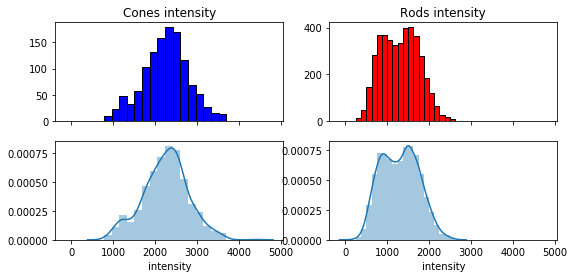

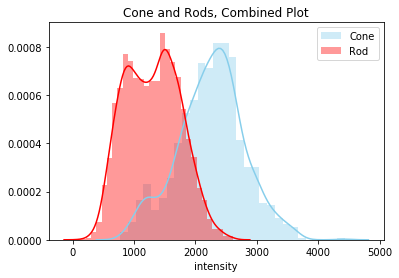

In [90]:
plot_cones_rods(df_cones.intensity, df_rods.intensity,"intensity")

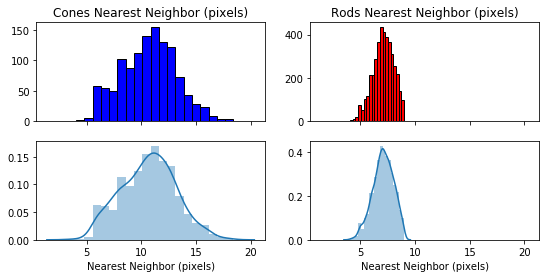

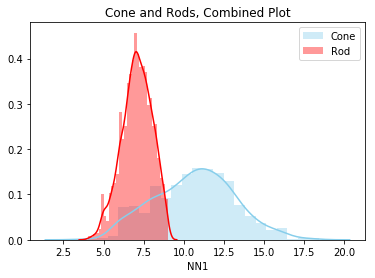

In [91]:
plot_cones_rods(df_cones.NN1, df_rods.NN1,"Nearest Neighbor (pixels)")

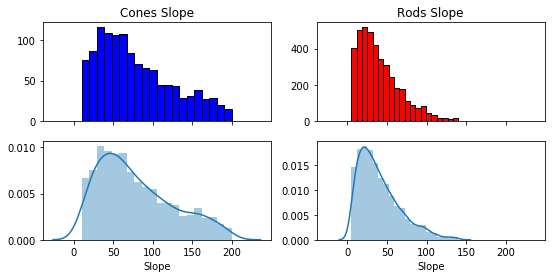

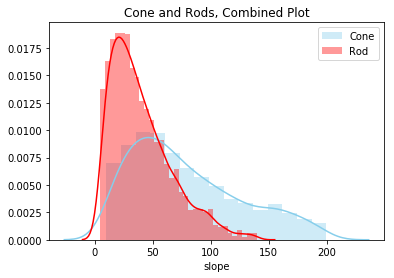

In [92]:
plot_cones_rods(df_cones.slope, df_rods.slope,"Slope")

In [93]:
# "type" is 1 for cones, 0 for rods. This is the target variable
y= df.type
x= df.copy()
x.drop(["type"], axis=1, inplace=True)

#x_train, x_valid, y_train, y_valid = train_test_split(X_all,y_all, test_size=0.2, random_state=42)
#x_train.head()

First we try a define a function for Logistic Regression. It will plot a Confusion matrix; first we run that function

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,recall_score, accuracy_score 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [95]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [96]:
def predict_logistic(x,y,features=[],do_scale=False,do_resamp=False, show_cm=False,normTF=False):
    
    if len(features)>0:
            x=x[features]
    
    # Split the train/validate data
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2,random_state=3)
    
    # Option for resampling
    if do_resamp:
        sm = SMOTE(random_state=0, ratio = 1.0)
        x_train, y_train = sm.fit_sample(x_train, y_train)
    
    model = LogisticRegression(random_state=0,solver='lbfgs', multi_class='ovr')
    
    # Option for Scaling
    if do_scale:
        classifier = Pipeline(steps = [('scaler',StandardScaler()),('model',model)])
    else:
        classifier = Pipeline(steps = [('model',model)])
        
    _=classifier.fit(x_train,y_train)
    y_predict = classifier.predict(x_val)
    
    # Evaluate the model with several scores
    scores = cross_val_score(classifier, x, y, cv=5, scoring='f1_macro')
    print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    auc = roc_auc_score(y_val, y_predict)
    print('AUC (log-reg)=',round(auc,5))
    
    recall = recall_score(y_val, y_predict)
    print('Recall(log-reg)='+str(round(recall,5))+'\n')
       
    
    if show_cm:
        plot_confusion_matrix(y_val, y_predict, classes=['rods','cones'],
                          normalize=normTF,
                          title=None,
                          cmap=plt.cm.Blues)
    return classifier

In [97]:
predict_logistic(x,y)

F1: 0.94 (+/- 0.01)
AUC (log-reg)= 0.94339
Recall(log-reg)=0.89922



Pipeline(memory=None,
         steps=[('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=0,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

We can improve upon those results by scaling our features, which are quite imbalanced. We can simply re-call our function, changing the scaling attribute.

F1: 0.93 (+/- 0.01)
AUC (log-reg)= 0.94145
Recall(log-reg)=0.89535

Confusion matrix, without normalization


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=0,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

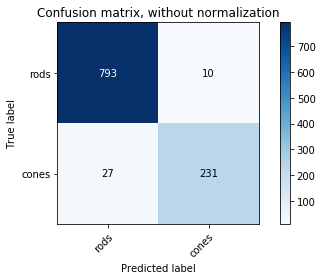

In [98]:
predict_logistic(x,y, do_scale=True, show_cm=True)

Applying the sklearn built-in StandardScaler offers a clear improvement in both AUC and recall. 

But, if we take a second to look at these metrics, the AUC value looks pomising but the recall is not as good as we might like. We can gain some insight into this by looking at the confusion matrix above. 

We can see that while rods are classified with fairly good accuraccy (few false positives), many cones are getting mis-classified as rods (false negatives). This can often be a problem for imblanced data, where one of the target classes occurs with much greater frequency (rods in this case). Over-sampling of the minority class often beneficial in this situation. We will be applying the Synthetic Minority Over-sampling (SMOTE) techiniqe. The following cell applies SMOTE without feature scaling.

F1: 0.93 (+/- 0.01)
AUC (log-reg)= 0.94146
Recall(log-reg)=0.93023

Confusion matrix, without normalization


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=0,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

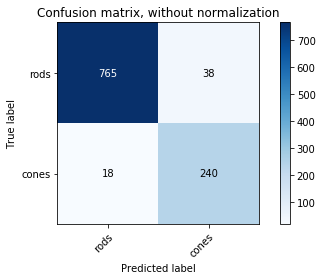

In [99]:
predict_logistic(x,y, do_scale=True, show_cm=True, do_resamp=True)

That worked really well! As we can see from the confusion matrix, the number of false negatives has been greatly reduced. 

Those results seem promising with a simple Logisitic Regression Classsifier. What about other classification techniques? Below, as Random Forest Classifier is used, creating a similar function as we did for logistic regression. 

In [128]:
from sklearn.ensemble import RandomForestClassifier

def predict_rand_for(x,y,features=[],do_scale=True,do_resamp=False, show_cm=False,normTF=False,n_est=100):
    
    if len(features)>0:
            x=x[features]
    
    # Split the training/validation sets
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2,random_state=3)
    
    # Option for resampling
    if do_resamp:
        sm = SMOTE(random_state=0, ratio = 1.0)
        x_train, y_train = sm.fit_sample(x_train, y_train)
    
    model = RandomForestClassifier(random_state=3, n_estimators=n_est)
    
    # Option for scaling
    if do_scale:
        classifier = Pipeline(steps = [('scaler',StandardScaler()),('model',model)])
    else:
        classifier = Pipeline(steps = [('model',model)])
        
    classifier.fit(x_train,y_train)
    
    # Evaluate the model with several scores
    scores = cross_val_score(classifier, x, y, cv=5, scoring='f1')
    print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    y_predict = classifier.predict(x_val)
    auc = roc_auc_score(y_val, y_predict)
    print('AUC (Rand-For)=',round(auc,5))
    recall = recall_score(y_val, y_predict)
    print('Recall (Rand-For)='+str(round(recall,5))+'\n')
    
    if show_cm:
        plot_confusion_matrix(y_val, y_predict, classes=['no default','default'],
                          normalize=normTF,
                          title=None,
                          cmap=plt.cm.Blues)
    return classifier
        

F1: 0.93 (+/- 0.02)
AUC (Rand-For)= 0.95564
Recall (Rand-For)=0.92248

Confusion matrix, without normalization


Pipeline(memory=None,
         steps=[('model',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=64, n_jobs=None,
                                        oob_score=False, random_state=3,
                                        verbose=0, warm_start=False))],
         verbose=False)

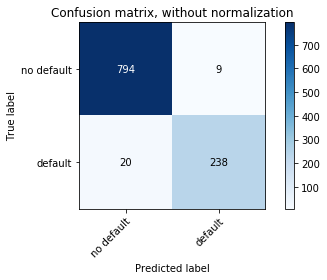

In [129]:
predict_rand_for(x,y, do_scale=False,do_resamp=False,show_cm=True,n_est=64)

These results are striking--using a Random Forest Model, with no scaling or resampling, we achieved roughly equivalent (actually slightly better) results right off the bat! 

Decision trees and random forest models should be scale invariant. We can easily invesigate this.

F1: 0.96 (+/- 0.01)
AUC (Rand-For)= 0.95564
Recall (Rand-For)=0.92248

Confusion matrix, without normalization


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=3,
                                        verbose=0, warm_start=False))],
         verbose=False)

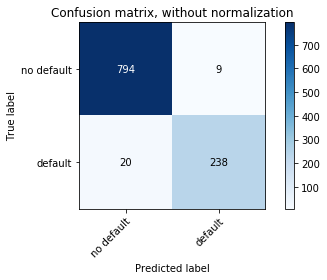

In [102]:
predict_rand_for(x,y, do_scale=True,do_resamp=False,show_cm=True)

Result are pretty similar, as expected. 

## Model Optimization

Now we can use a grid search approach to hyperparameter optimization

In [130]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2,random_state=3)
pipe = Pipeline([('classifier' , RandomForestClassifier())])
#np.logspace(-4, 4, 20)
#list(range(10,101,10))
#list(range(6,32,5))
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 8),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,201,6)),}]
    
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring = 'recall')
clf.fit(x_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    8.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('classifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
               

In [131]:
from sklearn.metrics import classification_report
def print_gridsearch_results(clf,x_valid, y_valid):
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    #y_true, y_pred = y_test, clf.predict(X_test)
    y_pred = clf.predict(x_valid)
    print(classification_report(y_valid, y_pred))
    print()

In [127]:
print_gridsearch_results(clf,x_valid,y_valid)

Best parameters set found on development set:

{'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=94,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'classifier__n_estimators': 94}

Grid scores on development set:

0.000 (+/-0.000) for {'classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), 'classifier__C': 0.